# Clipping WOA data using shapefile
This notebook accesses WOA data available through NOAA's thredds catalogue and loads it to memory. It then uses a shapefile to extract data for a region of interest.

## Loading relevant libraries

In [1]:
import xarray as xr
from netCDF4 import Dataset
import requests
import pandas as pd
import numpy as np
import rioxarray
import geopandas as gp
import matplotlib.pyplot as plt

C:\Users\ldfierro\AppData\Local\Temp\ipykernel_17624\583700583.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gp


## Constructing URL to access WOA data
This notebook uses the $1^{\circ}$ horizontal resolution from WOA. We used the statistical mean temperature datasets available [here](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/bin/woa18.pl).  
  
In the next code chunk, we will create a URL to access the data stored in the thredds server. Make sure you check the naming convention in this [page](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/bin/woa18.pl) for information on what information can be included under each variable used to create the full URL. Finally, note that all variables must be given as strings, **do not include numbers**.

In [2]:
#Base URL for the HTTPServer that hosts WOA data
base_url = 'https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/'
#Variable of interest
var = 'temperature'
#Product of interest - In this case we used the decadal mean
prod = 'decav'
#Horizontal resolution of our data - In this case it is one degree
res = '1.00'
#Time period of our data - In this case it is the first month of the decadal mean
time_period = '01'
#Constructing final URL
full_url = f'{base_url}{var}/{prod}/{res}/woa18_{prod}_t{time_period}_01.nc'
#Checking result
full_url

'https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/1.00/woa18_decav_t01_01.nc'

## Loading data to memory

We will not download the entire dataset. Instead, we will hold it in memory and only store the subsetted data.  
  
The following block of code may take a few minutes, so be patient.

In [3]:
#Accessing the data from the URL
link = requests.get(full_url).content
#Load data to memory. We do not store it on disk
remote = Dataset('woa18_decav_t01_01.nc', 'r', memory=link)
#Checking result
remote

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.6, ACDD-1.3
    title: World Ocean Atlas 2018 : sea_water_temperature January 1955-2017 1.00 degree
    summary: Climatological mean temperature for the global ocean from in situ profile data
    references: Locarnini, R. A., A. V. Mishonov, O. K. Baranova, T. P. Boyer, M. M. Zweng, H. E. Garcia, J. R. Reagan, D. Seidov, K. W. Weathers, C. R. Paver, I. V. Smolyar, 2019: World Ocean Atlas 2018, Volume 1: Temperature.  A. V. Mishonov, Technical Ed., NOAA Atlas NESDIS 81
    institution: National Centers for Environmental Information (NCEI)
    comment: global climatology as part of the World Ocean Atlas project
    id: woa18_decav_t01_01.nc
    naming_authority: gov.noaa.ncei
    sea_name: World-Wide Distribution
    time_coverage_start: 1955-01-01
    time_coverage_end: 2017-01-31
    time_coverage_duration: P63Y
    time_coverage_resolution: P01M
    geospatial_lat_min: -

We will load the dataset as an `xarray` dataset for easy data manipulation. Note that we are not decoding the `time` dimension because the units are given in months from a reference date and `xarray` cannot handle this format. We will check the original `time` units below.

In [5]:
print('time value is: ', remote['time'][0], '\ntime attributes: ', remote['time'])

time value is:  372.5 
time attributes:  <class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    standard_name: time
    long_name: time
    units: months since 1955-01-01 00:00:00
    axis: T
    climatology: climatology_bounds
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used


Note the units are given in months, but the value of `time` is given as a float (i.e., number which includes decimals). We will assume that this means that the time should be set for the middle of the month. We will use the above information to correct the `time` dimension in our dataset.

In [6]:
#Loading data as xarray
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(remote), decode_times=False)

#Getting value of time dimension as an integer. We calculate it as floor because we will change the reference date to the middle of the month
time_val = int(np.floor(ds.time.values.tolist()[0]))

#Reference date for the time dimension - Note the change to the middle of the month
reference_date = pd.to_datetime('1955-01-15 00:00:00')

#Correcting time dimension in xarray dataset
ds['time'] = [np.timedelta64(time_val, 'M')+reference_date]

#Checking result
ds

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 57, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) datetime64[ns] 1986-01-14T12:25:12
Dimensions without coordinates: nbounds
Data variables: (12/13)
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_an                (time, depth, lat, lon) float32 ...
    ...                  ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
    t_oa                (time, depth, lat, lon) float32 ...
    t_ma                (time, depth, lat, lon) float32 ...
    t_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

You may notice that our dataset has a number of variables available. This is why it took so long to load the data. For this example, we will only consider the `t_an` variable, which refers to the climatological mean monthly temperature for the entire water column. We will check the metadata for this variable below.

In [7]:
ds.t_an

<xarray.DataArray 't_an' (time: 1, depth: 57, lat: 180, lon: 360)>
[3693600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 1.4e+03 1.45e+03 1.5e+03
  * time     (time) datetime64[ns] 1986-01-14T12:25:12
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

## Subsetting dataset

We will save this information in a new variable so it is easier to access the data we are interested in. Remember that we accessed the means for the month of January only, so we will include this information in the variable name.

In [11]:
#Notice we are using the first index only because the first dimension (time) only included one timestep
ds_temp_clim_jan = ds.t_an[0]
#Checking result
ds_temp_clim_jan

<xarray.DataArray 't_an' (depth: 57, lat: 180, lon: 360)>
[3693600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 1.4e+03 1.45e+03 1.5e+03
    time     datetime64[ns] 1986-01-14T12:25:12
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

## Loading shapefile to extract data
These shapefiles are available in the GEM drive. Make sure you have them available in your computer before continuing. For this example, we will use the FAO and LME shapefile.

<Axes: >

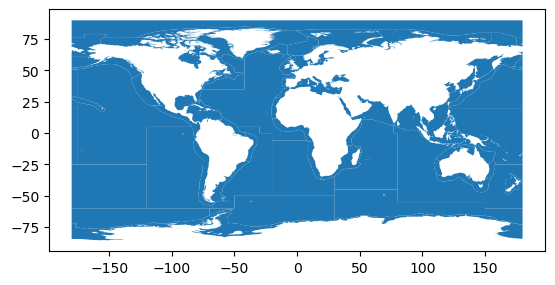

In [4]:
mask = gp.read_file('../Spatial_Data/Merged_FAO_LME/FAO-MajorAreas_LMEs.shp')
#We can check the result by plotting the mask
mask.plot()

We will use the Northwest Atlantic as an example, so we will create a new mask containing only this region.

<Axes: >

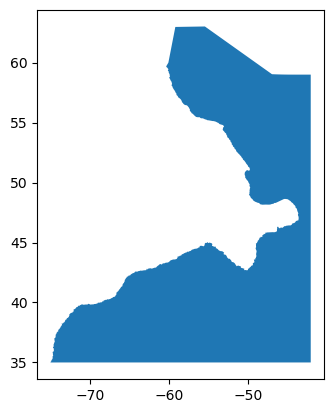

In [9]:
NWA = mask[mask.name_merge == 'Atlantic, Northwest']
NWA.plot()

We will include the WOA data and our mask into a single plot to ensure they are correctly aligned. We will use the first depthn available in the WOA dataset.

<Axes: title={'center': 'depth = 0.0 [meters], time = 1986-01-14T12:25:12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

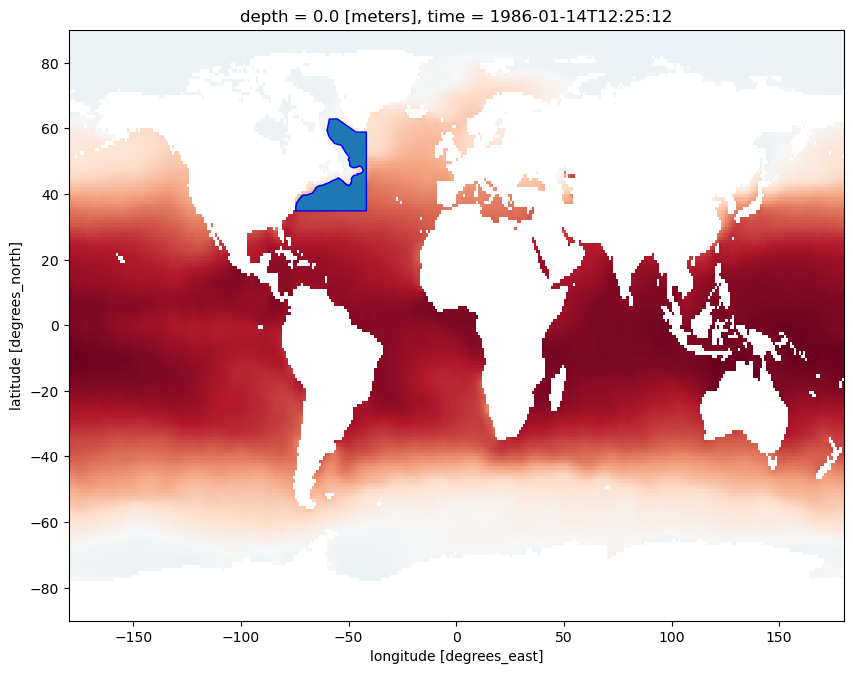

In [12]:
fig, ax = plt.subplots(figsize = (10,10))
ds_temp_clim_jan[0].plot(ax = ax, add_colorbar = False)
NWA.plot(ax = ax, edgecolor = 'b')

## Assigning coordinate reference system (CRS) to WOA dataset
Although, the WOA dataset does have information about CRS in its metadata, it has not been assigned yet. Next we will check and assign the correct CRS before clipping our dataset.

In [18]:
print('WOA CRS: ', ds.crs, '\nMask CRS: ', NWA.crs)

WOA CRS:  <xarray.DataArray 'crs' ()>
[1 values with dtype=int32]
Attributes:
    grid_mapping_name:            latitude_longitude
    epsg_code:                    EPSG:4326
    longitude_of_prime_meridian:  0.0
    semi_major_axis:              6378137.0
    inverse_flattening:           298.25723 
Mask CRS:  EPSG:4326


We can see that the mask and WOA dataset have the same CRS, which is just what we needed. We will now assign the correct CRS.

In [22]:
#The inplace argument is used to modify the original object
ds_temp_clim_jan.rio.write_crs(NWA.crs, inplace = True)

<xarray.DataArray 't_an' (depth: 57, lat: 180, lon: 360)>
[3693600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 1.4e+03 1.45e+03 1.5e+03
    time     datetime64[ns] 1986-01-14T12:25:12
    crs      int32 0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

## Clipping WOA dataset with shapefile
We are now ready to clip our dataset. We are using the `rioxarray` library to achieve this. To learn more about clipping and all options available to you, check their [tutorial](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html).

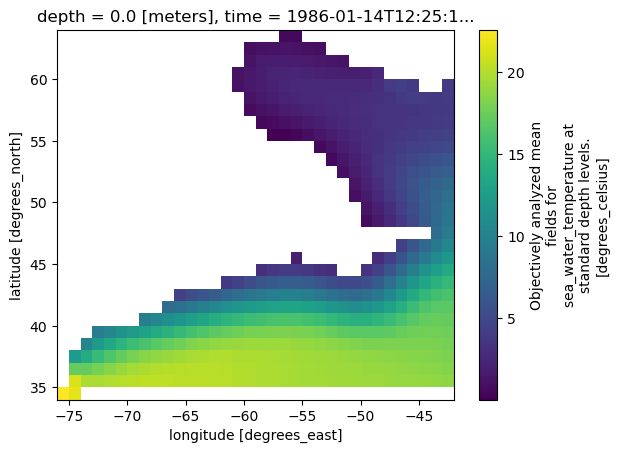

In [23]:
#Clipping dataset
clipped = ds_temp_clim_jan.rio.clip(NWA.geometry, NWA.crs, drop = True, all_touched = True)
#Checking result by plotting the first depth layer
clipped[0].plot()

## Saving clipped data
If you are happy with your results, you can save it to your disk with the line below.

In [ ]:
clipped.to_netcdf('WOA_Clim_Temp_NWA_1955-1964.nc')

You are done. You have successfully clipped the World Ocean Atlas data to the Northwest Atlantic and saved the clipped data to disk for use in further analysis.